In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture


df_nifty = pd.read_csv('NIFTY.csv')
df_vix = pd.read_csv('VIX.csv')
df_nifty["Date"] = pd.to_datetime(df_nifty["Date"])
df_vix["Date"] = pd.to_datetime(df_vix["Date"])

df_nifty.set_index("Date", inplace=True)
df_nifty.sort_values("Date", inplace=True)


df_vix.set_index("Date", inplace=True)
df_vix.sort_values("Date", inplace=True)


/var/folders/ss/4fy1wy_17qq9x8pms7k73r940000gn/T/ipykernel_11857/3818298247.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_nifty["Date"] = pd.to_datetime(df_nifty["Date"])
/var/folders/ss/4fy1wy_17qq9x8pms7k73r940000gn/T/ipykernel_11857/3818298247.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_vix["Date"] = pd.to_datetime(df_vix["Date"])


In [2]:
df_nifty

,Open,High,Low,Close
Date,,,,
2019-01-02,10851.35,10983.45,10813.45,10893.65
2019-01-03,10842.65,10877.90,10823.10,10863.50
2019-01-04,11665.20,11738.10,11644.75,11669.15
2019-01-07,11839.90,11884.65,11830.80,11865.60
2019-01-08,11060.20,11076.75,10881.00,10980.00
...,...,...,...,...
2025-12-02,23050.80,23144.70,22798.35,23045.25
2025-12-03,22536.35,22577.40,22329.55,22470.50
2025-12-05,24420.10,24944.80,24378.85,24924.70


In [3]:
class MicroFeatureExtractor:
    def __init__(self, df_nifty, df_vix, adx_window=3, per_window=3, vol_window=5):
        self.df_nifty = df_nifty.copy()
        self.df_vix = df_vix.copy()
        self.final_df = None
        self.adx_window = adx_window
        self.per_window = per_window
        self.vol_window = vol_window

    def _cci(self, window=14):
        tp = (self.df_nifty["High"] + self.df_nifty["Low"] + self.df_nifty["Close"]) / 3
        sma = tp.rolling(window).mean()
        mad = tp.rolling(window).apply(
            lambda x: np.mean(np.abs(x - x.mean())), raw=True
        )
        cci = (tp - sma) / (mad)
        self.df_nifty[f"CCI"] = cci

    def process_nifty(self):
        df = self.df_nifty
        df["Return"] = df["Close"].pct_change()

        # Volatility
        df["NIR"] = (df["High"] - df["Low"]) / (df["Close"].shift(1) + 1e-8)
        df["RV"] = df["Return"].rolling(self.vol_window).std() * np.sqrt(
            self.vol_window
        )
        # df['ATR'] = df[['High','Low','Close']].assign(prev_close=df['Close'].shift(1)).apply(
        #     lambda row: max(
        #         row['High']-row['Low'],
        #         abs(row['High']-row['prev_close']),
        #         abs(row['Low']-row['prev_close'])
        #     ), axis=1
        # ).rolling(self.vol_window).mean()

        # Trendiness / choppiness
        df["KER"] = np.abs(df["Close"] - df["Open"]) / (
            df["Return"].abs().rolling(self.per_window).sum() + 1e-8
        )

        # ADX simplified
        df["UpMove"] = df["High"] - df["High"].shift(1)
        df["DownMove"] = df["Low"].shift(1) - df["Low"]
        df["PlusDM"] = np.where(
            (df["UpMove"] > df["DownMove"]) & (df["UpMove"] > 0), df["UpMove"], 0
        )
        df["MinusDM"] = np.where(
            (df["DownMove"] > df["UpMove"]) & (df["DownMove"] > 0), df["DownMove"], 0
        )
        df["TR"] = (
            df[["High", "Low", "Close"]]
            .assign(prev_close=df["Close"].shift(1))
            .apply(
                lambda row: max(
                    row["High"] - row["Low"],
                    abs(row["High"] - row["prev_close"]),
                    abs(row["Low"] - row["prev_close"]),
                ),
                axis=1,
            )
        )
        df["PlusDI"] = (
            100
            * df["PlusDM"].rolling(self.adx_window).sum()
            / df["TR"].rolling(self.adx_window).sum()
        )
        df["MinusDI"] = (
            100
            * df["MinusDM"].rolling(self.adx_window).sum()
            / df["TR"].rolling(self.adx_window).sum()
        )
        df["ADX"] = abs(df["PlusDI"] - df["MinusDI"])

        # Optional: CCI for momentum info
        self._cci(window=14)

        self.df_nifty = df.dropna()

    def process_vix(self):
        df = self.df_vix
        df["VIX_Change"] = df["Close"].pct_change()
        df["NIR_VIX"] = (df["High"] - df["Low"]) / (df["Close"].shift(1) + 1e-8)
        df['VIX_smooth'] = df['Close'].ewm(span=5, adjust=False).mean()
        self.df_vix = df.dropna()

    def merge_dfs(self):
        self.df_merged = (
            self.df_nifty[
                [
                "NIR", 
                "RV", 
                "KER", 
                "ADX", 
                "Close", 
                "CCI"]]
            .join(self.df_vix[["Close", 
                               "VIX_Change", 
                               "NIR_VIX",
                               "VIX_smooth"]], how="inner", rsuffix=("_vix"))
            .rename(columns={"Close_vix": "VIX"})
        )
        self.df_merged = self.df_merged.dropna()
 
        self.final_df = self.df_merged.copy()

    def process_cross_features(self):
        df : pd.DataFrame = self.df_merged.copy()
        # df['VIX_RV_Spread'] = df['VIX'] - df['RV'] 
        df["VIX_ADX"] = df["VIX"] * df["ADX"] ## fear adjusted trendiness. 
        df = df.drop(columns=['ADX', 'VIX'])
        df = df.dropna()
        self.df_merged = df.copy()
        self.final_df = df.copy()
 
    def scale_df(self):
        features = self.df_merged.drop(columns=["Close"])
        self.scaler = StandardScaler()
        scaled_features = self.scaler.fit_transform(features)
        self.df_merged_scaled = pd.DataFrame(
            scaled_features, index=features.index, columns=features.columns
        )
        self.df_merged_scaled["Close"] = self.df_merged["Close"]
        self.final_df = self.df_merged_scaled.copy()

    def process(self):
        self.process_nifty()
        self.process_vix()
        self.merge_dfs()
        self.process_cross_features()
        self.scale_df()

In [4]:
ufe = MicroFeatureExtractor(df_nifty, df_vix)
ufe.process()

In [5]:
ufe.final_df

,NIR,RV,KER,CCI,VIX_Change,NIR_VIX,VIX_smooth,VIX_ADX,Close
Date,,,,,,,,,
2019-01-22,-0.464012,-0.930598,-0.084941,-0.418844,-0.178366,0.553904,-0.071211,-0.846528,10922.75
2019-01-23,0.056597,-0.870434,0.524705,-0.504813,0.078666,3.055300,-0.031522,-1.122631,10831.50
2019-01-24,-0.648363,-0.869235,-0.668554,-0.547005,-0.656266,1.212008,-0.034850,-0.411081,10849.80
2019-01-25,0.534168,-0.856080,0.294766,-0.545591,0.239204,1.272202,-0.025383,-1.250709,10780.55
2019-01-28,0.527157,-0.877133,0.738878,-0.924815,1.188968,1.929439,0.036264,-0.700159,10661.55
...,...,...,...,...,...,...,...,...,...
2025-08-14,-1.026130,0.388465,-0.667711,0.060475,0.301116,-0.539316,-0.764285,0.054175,24631.30
2025-08-18,-0.577272,0.005486,-0.121399,0.459629,-0.048451,0.223675,-0.756847,-0.093064,24876.95
2025-08-19,-0.731906,-0.323219,0.575851,0.532025,-0.809075,-1.013456,-0.777092,-0.102099,24980.65


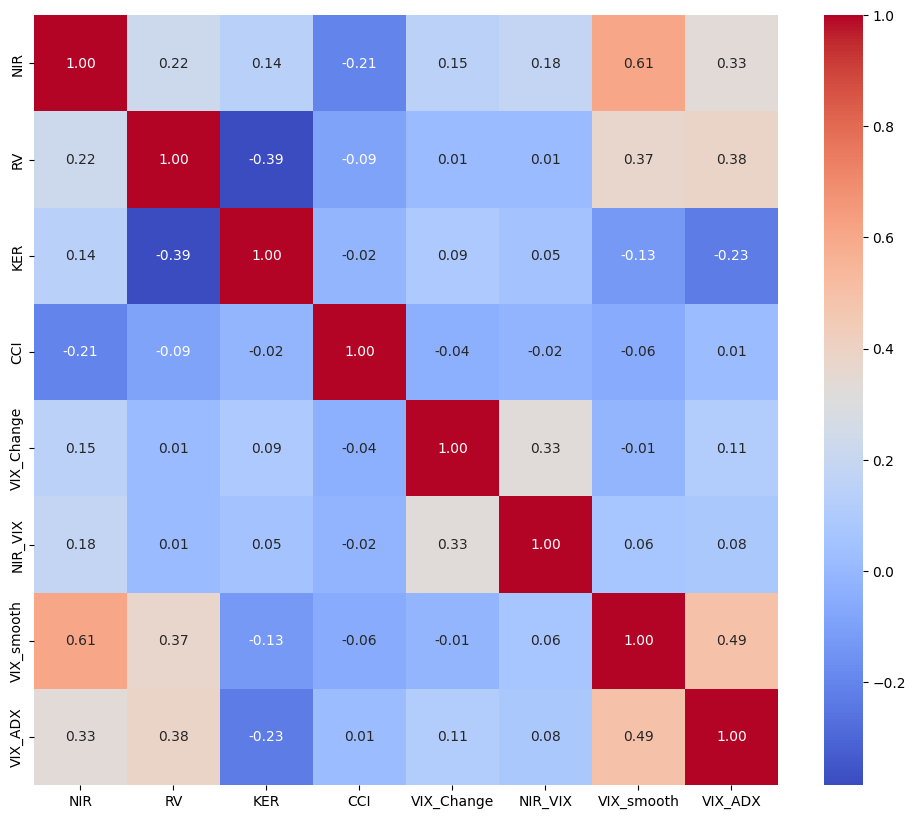

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = ufe.final_df.drop(columns=['Close']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [7]:
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

class RegimeClassifier:
    def __init__(self):
        pass
    
    def initialise_model(self, model_class, params: dict):
        """
        Initialise HMM (or any sklearn-like model) with params.
        """
        return model_class(**params)

    def get_regimes_hmm(self, input_data: np.ndarray, params: dict):
        """
        Train an HMM model on input_data and return fitted model + regimes.
        """
        X = np.array(input_data)
        hmm_model = self.initialise_model(GaussianHMM, params).fit(X)
        regimes = hmm_model.predict(X)
        return hmm_model, regimes

    def get_cluster_centres(self, hmm_model):
        """Return the mean vectors (cluster centres) for each regime."""
        return hmm_model.means_
    
    def get_cluster_variances(self, hmm_model):
        """Return the mean vectors (cluster centres) for each regime."""
        return hmm_model.covariances_
    
    def _count_hmm_params(self, model):
        """Count number of free parameters in Gaussian HMM."""
        M = model.n_components
        d = model.n_features
        cov_type = model.covariance_type
        
        init_params = M - 1
        trans_params = M * (M - 1)
        mean_params = M * d
        
        if cov_type == "full":
            cov_params = M * d * (d + 1) // 2
        elif cov_type == "diag":
            cov_params = M * d
        else:
            raise ValueError(f"Unsupported covariance type: {cov_type}")
        
        return init_params + trans_params + mean_params + cov_params

    def evaluate_models(self, X, ns=[2, 3, 4, 5, 6], n_init=10, random_state=None):
        """
        Fit HMMs with different numbers of components and evaluate using AIC, BIC, and log-likelihood.
        
        X : np.ndarray
        ns : list of int -> number of components to try
        n_init : int -> how many times to refit each model and keep the best
        random_state : int -> for reproducibility
        """
        aic, bic, lls = [], [], []
        
        for n in ns:
            best_ll = None
            best_model = None
            for i in range(n_init):
                h = GaussianHMM(n_components=n, n_iter=200, tol=1e-4, random_state=random_state)
                h.fit(X)
                score = h.score(X)
                if (best_ll is None) or (score > best_ll):
                    best_ll = score
                    best_model = h
            
            k = self._count_hmm_params(best_model)
            n_samples = len(X)
            AIC = 2 * k - 2 * best_ll
            BIC = np.log(n_samples) * k - 2 * best_ll
            
            aic.append(AIC)
            bic.append(BIC)
            lls.append(best_ll)

        # Plot results
        fig, ax = plt.subplots()
        ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
        ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
        ax2 = ax.twinx()
        ln3 = ax2.plot(ns, lls, label="Log-Likelihood", color="orange", marker="o")

        ax.legend(handles=ax.lines + ax2.lines)
        ax.set_title("Using AIC/BIC for Model Selection")
        ax.set_ylabel("Criterion Value (lower is better)")
        ax2.set_ylabel("Log-Likelihood (higher is better)")
        ax.set_xlabel("Number of HMM Components")
        fig.tight_layout()
        plt.show()
        
        # print({"ns": ns, "AIC": aic, "BIC": bic, "LogLikelihood": lls})



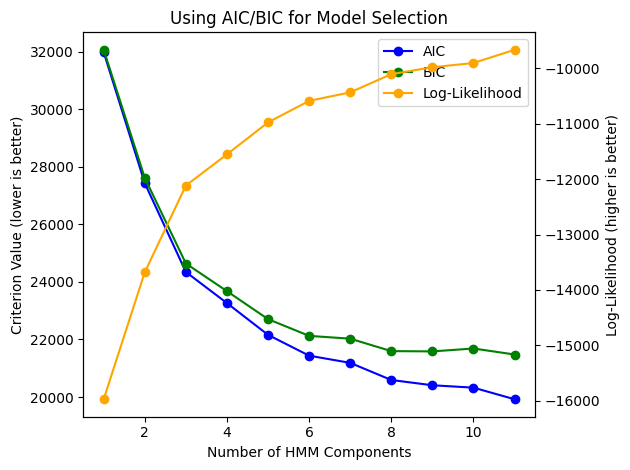

In [8]:

clf = RegimeClassifier()
results = clf.evaluate_models(ufe.final_df.drop(columns=['Close']), ns=list(range(1, 12)), n_init=10, random_state=42)

In [9]:

clf = RegimeClassifier()

params = {
    "n_components": 6,
    "covariance_type": "full",
    "n_iter": 50,        
    "tol": 1e-4,         
    "verbose": True,     
    "random_state": 42,
}

# new_df = (mfe.df_nifty.drop(columns=['Close']).copy())
ufe = MicroFeatureExtractor(df_nifty, df_vix)
ufe.process()
                 
model, regimes = clf.get_regimes_hmm(ufe.final_df.drop(columns=['Close']), params)
ufe.final_df["Regime"] = regimes

         1  -15398.26001794             +nan
         2  -12954.17685060   +2444.08316734
         3  -12308.90471558    +645.27213503
         4  -12015.23869979    +293.66601579
         5  -11798.49837473    +216.74032506
         6  -11602.45762016    +196.04075457
         7  -11364.38954270    +238.06807745
         8  -11146.96484741    +217.42469529
         9  -10981.86322155    +165.10162587
        10  -10837.96978852    +143.89343302
        11  -10678.24139747    +159.72839105
        12  -10584.25931737     +93.98208010
        13  -10505.14001820     +79.11929917
        14  -10445.70796621     +59.43205199
        15  -10369.17583298     +76.53213323
        16  -10310.95649619     +58.21933679
        17  -10274.43466803     +36.52182816
        18  -10260.65464417     +13.78002385
        19  -10256.54117567      +4.11346850
        20  -10253.83876106      +2.70241461
        21  -10251.11980823      +2.71895284
        22  -10248.13693636      +2.98287186
        23

In [10]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture

# Suppose your data is in df_features
# Columns: ['RV', 'ATR', ...]

# Compute F-statistic for each feature
f_stats = {}
for col in ufe.final_df.columns[:-1]:  # exclude 'cluster'
    between_var = ufe.final_df.groupby('Regime')[col].mean().var()
    within_var = ufe.final_df.groupby('Regime')[col].var().mean()
    f_stats[col] = between_var / within_var

# Sort features by F-statistic
f_stats = dict(sorted(f_stats.items(), key=lambda item: item[1], reverse=True))
print("Feature relevance (F-statistic):")
for feature, f_val in f_stats.items():
    print(f"{feature}: {f_val:.4f}")

Feature relevance (F-statistic):
RV: 2.3920
VIX_smooth: 1.5551
Close: 0.7071
VIX_ADX: 0.6942
KER: 0.5800
NIR: 0.4586
NIR_VIX: 0.2698
CCI: 0.0145
VIX_Change: 0.0127


In [24]:
ufe.final_df

,NIR,RV,KER,CCI,VIX_Change,NIR_VIX,VIX_smooth,VIX_ADX,Close,micro_regime
Date,,,,,,,,,,
2019-01-22,-0.464012,-0.930598,-0.084941,-0.418844,-0.178366,0.553904,-0.071211,-0.846528,10922.75,Trending_LowVol
2019-01-23,0.056597,-0.870434,0.524705,-0.504813,0.078666,3.055300,-0.031522,-1.122631,10831.50,Trending_LowVol
2019-01-24,-0.648363,-0.869235,-0.668554,-0.547005,-0.656266,1.212008,-0.034850,-0.411081,10849.80,Trending_LowVol
2019-01-25,0.534168,-0.856080,0.294766,-0.545591,0.239204,1.272202,-0.025383,-1.250709,10780.55,Trending_LowVol
2019-01-28,0.527157,-0.877133,0.738878,-0.924815,1.188968,1.929439,0.036264,-0.700159,10661.55,Trending_LowVol
...,...,...,...,...,...,...,...,...,...,...
2025-08-14,-1.026130,0.388465,-0.667711,0.060475,0.301116,-0.539316,-0.764285,0.054175,24631.30,Choppy_LowVol
2025-08-18,-0.577272,0.005486,-0.121399,0.459629,-0.048451,0.223675,-0.756847,-0.093064,24876.95,Trending_LowVol
2025-08-19,-0.731906,-0.323219,0.575851,0.532025,-0.809075,-1.013456,-0.777092,-0.102099,24980.65,Trending_LowVol


In [12]:
centres = pd.DataFrame(ufe.scaler.inverse_transform(clf.get_cluster_centres(model)), columns=ufe.final_df.drop(columns=['Close', 'Regime']).columns)

In [13]:
print(centres)

        NIR        RV          KER       CCI  VIX_Change   NIR_VIX  \
0  0.010862  0.044416  5161.530109  0.094495    0.007509  0.155636   
1  0.012171  0.135645   689.477418  0.087179   -0.001392  0.110846   
2  0.029985  0.283383   708.884309  0.083271    0.003556  0.110606   
3  0.009895  0.015235  6468.771241  0.083934   -0.003933  0.098952   
4  0.008978  0.102473   840.157511  0.092287   -0.002084  0.104580   
5  0.018603  0.089276  3534.934555 -0.380827    0.015423  0.196142   

   VIX_smooth      VIX_ADX  
0   16.852590   641.830528  
1   20.593593  1039.990142  
2   40.974001  2076.323830  
3   15.241211   456.802108  
4   13.903885   756.708030  
5   24.384950   960.245222  


	•	Cluster 0 → Trending_LowVol
	•	Cluster 1 → Choppy_MidVol
	•	Cluster 2 → Choppy_HighVol
	•	Cluster 3 → Trending_VeryLowVol
	•	Cluster 4 → Choppy_LowVol
	•	Cluster 5 → Neutral_MidVol

In [14]:
ufe.final_df.rename(columns={"Regime": "micro_regime"}, inplace=True)
ufe.final_df["micro_regime"].replace(
    {
        0: "Trending_LowVol",
        1: "Choppy_MidVol",
        2: "Choppy_HighVol",
        3: "Trending_VeryLowVol",
        4: "Choppy_LowVol",
        5: "Neutral_MidVol"
    },
    inplace=True,
)

/var/folders/ss/4fy1wy_17qq9x8pms7k73r940000gn/T/ipykernel_11857/3183758244.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ufe.final_df["micro_regime"].replace(


In [17]:
import plotly.express as px

def plot_graph_interactive(df):
    print(df["micro_regime"].value_counts())

    # ensure categorical regimes
    df = df.copy()
    df["micro_regime"] = df["micro_regime"].astype(str)

    for col in df.columns:
        if col == "micro_regime":
            continue

        if col.lower() == "close":
            # Scatter plot for Close
            fig = px.scatter(
                df,
                x=df.index,
                y=col,
                color="micro_regime",
                title=f"{col} vs Date (colored by regime)",
                labels={"x": "Date", col: col},
                opacity=0.7
            )
            fig.update_traces(marker=dict(size=4))
            fig.update_layout(
                legend_title_text="micro_regime",
                hovermode="x unified"
            )
        else:
            # Violin plot for numeric columns
            fig = px.violin(
                df,
                y=col,
                color="micro_regime",
                box=True,      # shows box inside violin
                points="all",  # show all points
                title=f"Distribution of {col} by Regime",
                hover_data=df.columns
            )
            fig.update_layout(
                legend_title_text="micro_regime"
            )

        fig.show()

# Usage
plot_graph_interactive(ufe.final_df)

micro_regime
Trending_VeryLowVol    401
Choppy_LowVol          359
Trending_LowVol        270
Choppy_MidVol          201
Neutral_MidVol         125
Choppy_HighVol          51
Name: count, dtype: int64


In [20]:
import pandas as pd


def compute_regime_persistence(df, regime_col="micro_regime"):
    # Mark changes in regime
    df = df.copy()
    df["micro_regime_change"] = df[regime_col].ne(df[regime_col].shift()).cumsum()

    # Group consecutive same-regime stretches
    persistence = (
        df.groupby([regime_col, "micro_regime_change"])
        .size()
        .reset_index(name="Duration")
    )

    # For each regime, compute stats
    summary = (
        persistence.groupby(regime_col)["Duration"]
        .agg(["count", "mean", "median", "max", "min"])
        .reset_index()
    )
    
    return persistence, summary

# Example usage
# persistence: each streak (regime, duration)
# summary: regime-wise persistence stats
persistence, summary = compute_regime_persistence(ufe.final_df, regime_col="micro_regime")

print("\nSummary by regime:")
print(summary)


Summary by regime:
          micro_regime  count       mean  median  max  min
0       Choppy_HighVol      5  10.200000    10.0   20    4
1        Choppy_LowVol     53   6.773585     8.0   11    1
2        Choppy_MidVol     31   6.483871     7.0   13    1
3       Neutral_MidVol     46   2.717391     2.0    9    1
4      Trending_LowVol     95   2.842105     2.0    8    1
5  Trending_VeryLowVol     80   5.012500     5.0   12    1


In [23]:
ufe.final_df.to_csv("micro_regimes_classified.csv")